# Classify Images of Flowers using Transfer Learning
**Purpose**:  
Classify images of flowers with transfer learning using TensorFlow Hub, Google's Flowers Dataset, and MobileNet v2.

Dataset Used: [Flower dataset from Google](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)


Project based on [TensorFlow's classification example](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c02_exercise_flowers_with_transfer_learning.ipynb)


In [1]:
# import tf and dependencies
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

**Set up**  
1. Download the flowers dataset
2. Print info and reformat images
3. Create batches

In [3]:
# download the flowers dataset
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split = ['train[:70%]', 'train[70%:]']
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [6]:
# print info about the flowers dataset
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1


print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

# print size of images
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [12]:
# reformat images
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

# create batches
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)



**Do Transfer Learning with TensorFlow Hub**  
1. Create a Feature Extractor using MobileNet v2
2. Freeze the pretrained model
3. Attach a classification head
4. Train the model
5. Plot training and validation graphs

In [14]:
# create a feature extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [17]:
# freeze the variables in the feature extractor layer
feature_extractor.trainable = False

In [21]:
# attach a classification head
model = tf.keras.Sequential([
                feature_extractor,
                layers.Dense(num_classes)             
])

In [24]:
# train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)
EPOCHS = 6
history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 14s 58ms/step - loss: 1.1156 - accuracy: 0.5641 - val_loss: 0.4587 - val_accuracy: 0.8556
Epoch 2/6
81/81 [==============================] - 4s 49ms/step - loss: 0.3950 - accuracy: 0.8674 - val_loss: 0.3612 - val_accuracy: 0.8828
Epoch 3/6
81/81 [==============================] - 4s 51ms/step - loss: 0.3087 - accuracy: 0.8986 - val_loss: 0.3212 - val_accuracy: 0.9037
Epoch 4/6
81/81 [==============================] - 4s 49ms/step - loss: 0.2578 - accuracy: 0.9256 - val_loss: 0.3074 - val_accuracy: 0.9010
Epoch 5/6
81/81 [==============================] - 4s 49ms/step - loss: 0.2253 - accuracy: 0.9388 - val_loss: 0.2898 - val_accuracy: 0.9074
Epoch 6/6
81/81 [==============================] - 4s 49ms/step - loss: 0.1858 - accuracy: 0.9542 - val_loss: 0.2880 - val_accuracy: 0.9119


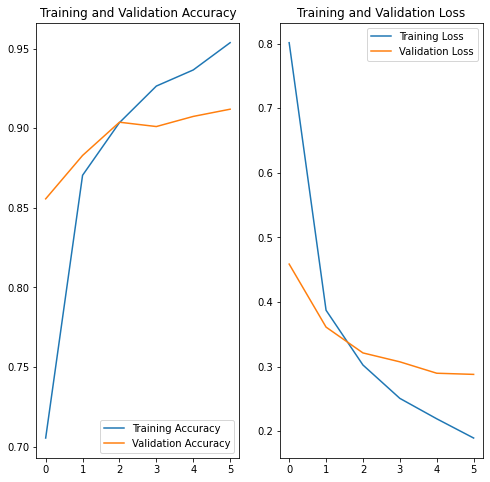

In [25]:
# plot training and validation graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
# check predictions against actual and convert class names into numpy array
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [30]:
# create an image batch 

image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['sunflowers' 'tulips' 'roses' 'roses' 'daisy' 'tulips' 'roses' 'daisy'
 'tulips' 'daisy' 'roses' 'tulips' 'sunflowers' 'daisy' 'sunflowers'
 'roses' 'dandelion' 'tulips' 'sunflowers' 'tulips' 'dandelion'
 'dandelion' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'sunflowers'
 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion']


In [31]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [3 2 4 4 1 2 4 1 2 1 4 2 3 1 3 4 0 2 3 2 0 0 0 2 2 3 3 0 0 0 1 0]
Predicted labels:  [3 2 4 4 1 2 4 1 2 1 4 2 3 1 3 4 0 2 3 2 0 0 0 2 2 3 3 0 0 0 0 0]


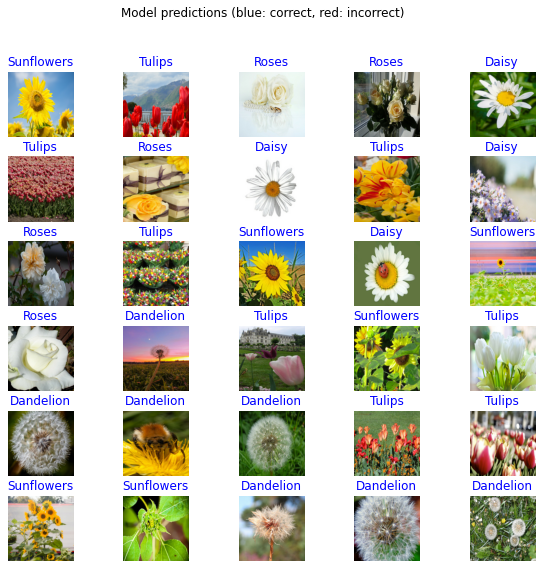

In [32]:
# plot
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

**Extension: Perform Transfer Learning with the Inception Model**

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [33]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

model_inception = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [36]:
model_inception.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 21s 195ms/step - loss: 1.0521 - accuracy: 0.5781 - val_loss: 0.4720 - val_accuracy: 0.8474
Epoch 2/6
81/81 [==============================] - 14s 174ms/step - loss: 0.3986 - accuracy: 0.8834 - val_loss: 0.3667 - val_accuracy: 0.8810
Epoch 3/6
81/81 [==============================] - 14s 177ms/step - loss: 0.3151 - accuracy: 0.9063 - val_loss: 0.3184 - val_accuracy: 0.9037
Epoch 4/6
81/81 [==============================] - 15s 181ms/step - loss: 0.2559 - accuracy: 0.9314 - val_loss: 0.3034 - val_accuracy: 0.8946
Epoch 5/6
81/81 [==============================] - 15s 180ms/step - loss: 0.2192 - accuracy: 0.9370 - val_loss: 0.2861 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 14s 177ms/step - loss: 0.2010 - accuracy: 0.9473 - val_loss: 0.2816 - val_accuracy: 0.9101


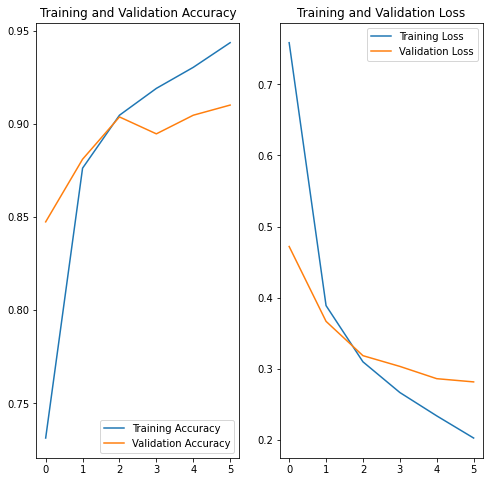

In [37]:
# plot training and validation graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [39]:
# check predictions against actual and convert class names into numpy array
class_names = np.array(dataset_info.features['label'].names)
class_names

# create an image batch 

image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

['daisy' 'dandelion' 'dandelion' 'tulips' 'roses' 'daisy' 'daisy' 'roses'
 'daisy' 'dandelion' 'roses' 'tulips' 'sunflowers' 'tulips' 'daisy'
 'daisy' 'dandelion' 'dandelion' 'tulips' 'daisy' 'roses' 'tulips'
 'tulips' 'daisy' 'sunflowers' 'sunflowers' 'roses' 'sunflowers' 'tulips'
 'roses' 'dandelion' 'roses']
Labels:  [1 0 2 2 4 1 1 4 1 0 4 2 3 2 1 1 0 0 2 1 4 2 2 1 3 3 4 3 2 4 0 4]
Predicted labels:  [1 0 0 2 4 1 1 4 1 0 4 2 3 2 1 1 0 0 2 1 4 2 2 1 3 3 4 3 2 4 0 4]


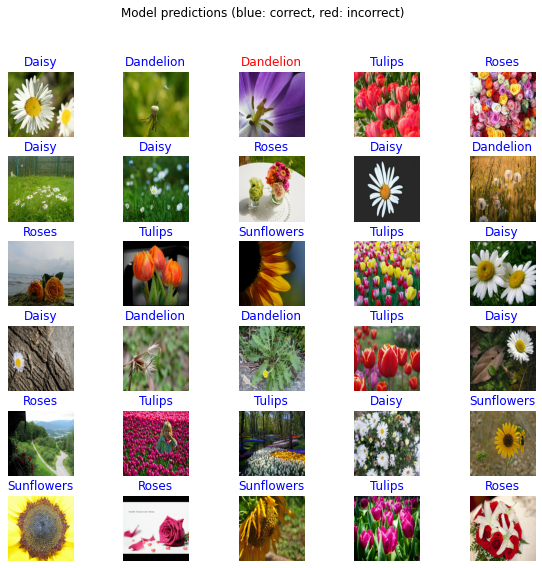

In [40]:
# plot
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")